In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import time
from matplotlib.collections import PatchCollection
%matplotlib inline

In [8]:
viewingDistance = 100
radius = 10
speed = 1
dotNum = 1000
timePoints = 1000
pixelsPerDegree = 10 

In [3]:
#pick dots at random screen positions with respect to center point
centerPos=np.array([50,50])
pos = np.random.randint(low=-pixelsPerDegree*90, high=pixelsPerDegree*90, size=dotNum*2).reshape(dotNum,2) + centerPos

#find how far they are from center and find unit vectors along which to move them
distToCenter = np.sqrt(np.sum((pos - centerPos)**2, axis=1))
unitVectors = (pos - centerPos)/distToCenter[:, None]

In [4]:
#find the visual angle at which each dot lives
theta = np.deg2rad(distToCenter/pixelsPerDegree)

#find the "time point" when each dot would reach its visual angle if it had started at the original viewing distance
virtualTimePoint = (viewingDistance - (radius/np.tan(theta)))/speed

#probably unnecessary
newTheta = np.copy(theta)
newPos = np.copy(pos)

In [9]:
#Function to repopulate dots that are past 90 degrees visual angle
def repop(repopInds, distToCenter, newPos, unitVectors, newTheta, virtualTimePoint):
    newPos[repopInds] = np.random.randint(low=-pixelsPerDegree*10, high=pixelsPerDegree*10, size=2*repopInds.size).reshape(repopInds.size,2)+centerPos
    distToCenter[repopInds] = np.sqrt(np.sum((newPos[repopInds] - centerPos)**2, axis=1))
    unitVectors[repopInds] = (newPos[repopInds] - centerPos)/distToCenter[repopInds, None]
    newTheta[repopInds] = np.deg2rad(distToCenter[repopInds]/pixelsPerDegree)
    virtualTimePoint[repopInds] = (viewingDistance - (radius/np.tan(newTheta[repopInds])))/speed
    
    return distToCenter, newPos, unitVectors, newTheta, virtualTimePoint

#Function to redraw dots for the next time point
def redraw(distToCenter, newPos, unitVectors, newTheta, virtualTimePoint):
    #increment "time point" for each dot
    virtualTimePoint += 1
    
    #find new visual angle at that time point
    newTheta = np.arctan(radius/(viewingDistance - speed*(virtualTimePoint+1)))
    
    #repop if necessary
    if any(np.rad2deg(newTheta)<0):
        repopInds = np.where(np.rad2deg(newTheta)<0)[0]
        distToCenter, newPos, unitVectors, newTheta, virtualTimePoint = repop(repopInds, distToCenter, pos, unitVectors, newTheta, virtualTimePoint)
    
    #convert angle to pixels and update dot positions
    newThetaPix = np.rad2deg(newTheta)*pixelsPerDegree
    newPos = unitVectors*newThetaPix[:, None] + centerPos
    
    return distToCenter, newPos, unitVectors, newTheta, virtualTimePoint
    
pos_array = []
for i in np.arange(timePoints):
    distToCenter, newPos, unitVectors, newTheta, virtualTimePoint = redraw(distToCenter, newPos, unitVectors, newTheta, virtualTimePoint)
    pos_array.append(newPos)
    

In [10]:
pos_array = np.array(pos_array)
pos_array.shape

(1000L, 1000L, 2L)

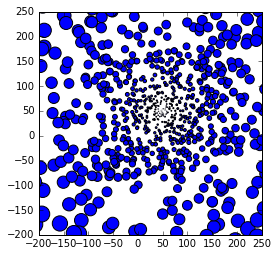

In [11]:
from ipywidgets import widgets, interact, interactive
from IPython.display import display
from IPython.display import Image

scaleFactor = 1/20.
fig, ax = plt.subplots()
ax.set_aspect('equal')
def f(x=0):
    patches = []
    for p in pos_array[x]:
        dist = ((p[0] - centerPos[0])**2 + (p[1]-centerPos[1])**2)**0.5
        radius = dist*scaleFactor
        patches.append(matplotlib.patches.Circle((p[0], p[1]), radius=radius, ec='none', fc=[0, 0, 0]))
    
    collection = PatchCollection(patches)
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.add_collection(collection)
    ax.set_ylim([-200, 250])
    ax.set_xlim([-200, 250])
    
interact(f, x=(0,timePoints-1,1));